In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import LayoutLMv2Processor, BertForTokenClassification, AutoTokenizer, AdamW, BertTokenizer, LayoutLMv2Tokenizer
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.trainer import BertTrainer

/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [4]:
model_name = "bert"
dataset_name = "sroie"

In [5]:
logging.basicConfig(filename='logs/bert_sroie.log', encoding='utf-8', level= logging.INFO)

## Obtaining data

In [6]:
dataset = load_dataset("darentang/sroie")

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 626
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 347
    })
})

In [8]:
n_classes = len(dataset['train'].features['ner_tags'].feature.names)

In [9]:
bert_tokenizer =AutoTokenizer.from_pretrained("bert-base-uncased")

In [10]:
train_dataset = ImageLayoutDataset(
    dataset['train'],
    bert_tokenizer,
)

  0%|          | 0/626 [00:00<?, ?it/s]

100%|██████████| 626/626 [00:03<00:00, 171.33it/s]


In [11]:
validation_dataset = ImageLayoutDataset(
    dataset['test'],
    bert_tokenizer    
)

  0%|          | 0/347 [00:00<?, ?it/s]

100%|██████████| 347/347 [00:02<00:00, 171.03it/s]


In [12]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=2
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1
)

## Importing model

In [13]:
device = "cuda"

In [14]:
bert = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels = n_classes)
bert.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [15]:
trainer = BertTrainer(
    bert
)

In [16]:
trainer.compile(
    train_dataloader,
    validation_dataloader,
    n_classes= n_classes,
    device = "cuda"
)

/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:47<00:00, 22.80s/it]


In [17]:
trainer.history['validation-f1'][-1]

0.983540415763855

In [18]:
best_idx = None
for idx, f1 in enumerate(trainer.history['validation-f1']):
    if f1 == trainer.best_f1:
        best_idx = idx 

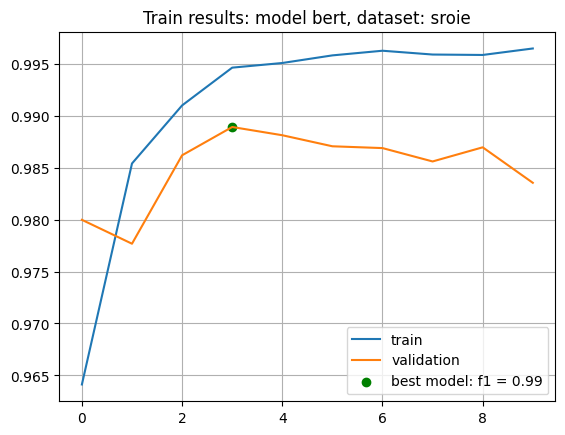

In [19]:
plt.plot(trainer.history['train-f1'],
         label = "train")
plt.plot(trainer.history['validation-f1'],
         label = "validation")

plt.title(f"Train results: model {trainer.model_name}, dataset: {dataset_name}")
plt.scatter(
    best_idx,
    trainer.best_f1.item(), 
    color = "green",
    label = f"best model: f1 = {round(trainer.best_f1.item(), 2)}"
) 
plt.grid()
plt.legend()

In [20]:
trainer.history['validation-f1']

[0.979976236820221,
 0.9776743650436401,
 0.9861888289451599,
 0.9889114499092102,
 0.9881194233894348,
 0.9870551228523254,
 0.9868818521499634,
 0.9855947494506836,
 0.9869561195373535,
 0.983540415763855]

In [21]:
trainer.history['train-f1']

[0.9641228914260864,
 0.9853994846343994,
 0.9909900426864624,
 0.9946265816688538,
 0.9950743317604065,
 0.9958071112632751,
 0.9962548613548279,
 0.9958885312080383,
 0.9958478212356567,
 0.9964720010757446]